In [30]:
import tensorflow as tf
import os
from xml.etree import ElementTree
import cv2
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split

In [21]:
os.chdir(r"C:\Users\theda\OneDrive - Arizona State University\ASU MSBA\Team 23893\CIS 515 Group Project")

In [22]:
class_names = ['pedestrians','riders','partially-visible persons','ignore regions','crowd']
class_names_label = {class_name:i for i, class_name in enumerate(class_names)}

n_classes = 5
size = (224,224)

In [23]:
filespath = "C:/Users/theda/OneDrive - Arizona State University/ASU MSBA/Team 23893/CIS 515 Group Project/WiderPerson"
os.chdir(filespath)
train_list = pd.read_csv("train.txt", header=None, dtype="string") + '.jpg'
test_list = pd.read_csv("test.txt", header=None, dtype="string") + '.jpg'
val_list = pd.read_csv("val.txt", header=None, dtype="string") + '.jpg'

In [24]:
train_images = []
train_labels = []
total_images = []
total_labels = []
#test_imags = []
#test_labels = []
val_images = []
val_labels = []
directoryA = "/Annotations/"
directoryIMG = "/Images/"

In [25]:
total_list = train_list.append(val_list).reset_index()

C:\Users\theda\AppData\Local\Temp\ipykernel_23192\1544342114.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_list = train_list.append(val_list).reset_index()


In [88]:
total_labels

array([[1, 0, 1, 0, 0],
       [1, 0, 1, 0, 1],
       [1, 0, 1, 0, 1],
       ...,
       [1, 0, 1, 0, 0],
       [1, 1, 0, 0, 1],
       [1, 0, 0, 1, 0]], dtype=int64)

In [26]:
for i in range(len(total_list)):
    img_path = filespath + directoryIMG + total_list[0][i]
    label_path = filespath + directoryA + total_list[0][i] + '.txt'
    curr_img = cv2.imread(img_path)
    curr_img = cv2.resize(curr_img, size)
    total_images.append(curr_img)
    test = pd.read_csv(label_path, header=None, skiprows=[0], sep=" ")[0].unique()
    pedestrians = 0
    riders = 0
    pv_person = 0
    ignore = 0
    crowd = 0
    for j in range(len(test)):
        if test[j]==1:
            pedestrians = 1
        elif test[j]==2:
            riders = 1
        elif test[j]==3:
            pv_person = 1
        elif test[j]==4:
            ignore = 1
        elif test[j]==5:
            crowd = 1
    total_labels.append([total_list[0][i], pedestrians, riders, pv_person, ignore, crowd])

total_images = np.array(total_images, dtype='float32')
total_images = total_images / 255
total_labels = np.array(pd.DataFrame(total_labels, columns=['id','0','1','2','3','4']).set_index('id'))

In [31]:
train_images, val_images, train_labels, val_labels = train_test_split(total_images, total_labels, test_size=0.25)

In [ ]:
# https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPool2D
# https://www.tensorflow.org/api_docs/python/tf/keras/layers/AveragePooling2D
# https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D
# https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense
# https://www.tensorflow.org/api_docs/python/tf/keras/layers/Flatten

In [ ]:
#(train_images, train_labels),(test_images, test_labels),(val_images, val_labels) = load_data()

In [35]:
val_images.shape

(2250, 224, 224, 3)

In [36]:
model_alex = tf.keras.models.Sequential([
    tf.keras.Input(shape=(224,224,3)),
    tf.keras.layers.Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    tf.keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    tf.keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(4096, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(4096, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(5, activation='sigmoid')
])

model_alex.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 54, 54, 96)        34944     
                                                                 
 batch_normalization (BatchN  (None, 54, 54, 96)       384       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 26, 26, 96)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 26, 26, 256)       614656    
                                                                 
 batch_normalization_1 (Batc  (None, 26, 26, 256)      1024      
 hNormalization)                                                 
                                                        

In [50]:
model_alex.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9),
              loss='binary_crossentropy',
              metrics=['binary_accuracy'])

In [51]:
# Save model after training (saves the model after N epoch)
filepath = "C:/Users/theda/OneDrive - Arizona State University/ASU MSBA/Team 23893/CIS 515 Group Project/WiderPerson"
model_alex.save(filepath)
# Customize the saving process during training
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=1, min_lr=0.00001)
#cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=filepath, save_best_only=True, monitor="val_accuracy", mode="max", verbose=1) # Saves only the best model (i.e., for each epoch during training, save model only if the current version outperforms the previous version)

alex_history = model_alex.fit(train_images, train_labels, epochs=90, batch_size=128, validation_data=(val_images, val_labels), callbacks=[reduce_lr])

INFO:tensorflow:Assets written to: C:/Users/theda/OneDrive - Arizona State University/ASU MSBA/Team 23893/CIS 515 Group Project/WiderPerson\assets


INFO:tensorflow:Assets written to: C:/Users/theda/OneDrive - Arizona State University/ASU MSBA/Team 23893/CIS 515 Group Project/WiderPerson\assets


Epoch 1/90
53/53 [==============================] - 541s 10s/step - loss: 0.4790 - binary_accuracy: 0.8289 - val_loss: 0.3539 - val_binary_accuracy: 0.8586 - lr: 0.0100
Epoch 2/90
53/53 [==============================] - 552s 10s/step - loss: 0.3647 - binary_accuracy: 0.8474 - val_loss: 0.3720 - val_binary_accuracy: 0.8586 - lr: 0.0100
Epoch 3/90
53/53 [==============================] - 521s 10s/step - loss: 0.3620 - binary_accuracy: 0.8548 - val_loss: 0.3929 - val_binary_accuracy: 0.8565 - lr: 1.0000e-03
Epoch 4/90
53/53 [==============================] - 526s 10s/step - loss: 0.3494 - binary_accuracy: 0.8528 - val_loss: 0.3875 - val_binary_accuracy: 0.8577 - lr: 1.0000e-04
Epoch 5/90
53/53 [==============================] - 516s 10s/step - loss: 0.3508 - binary_accuracy: 0.8523 - val_loss: 0.3861 - val_binary_accuracy: 0.8576 - lr: 1.0000e-05
Epoch 6/90
53/53 [==============================] - 517s 10s/step - loss: 0.3496 - binary_accuracy: 0.8537 - val_loss: 0.3852 - val_binary_accu

KeyboardInterrupt: 

In [52]:
model_alex.save(filepath)

INFO:tensorflow:Assets written to: C:/Users/theda/OneDrive - Arizona State University/ASU MSBA/Team 23893/CIS 515 Group Project/WiderPerson\assets


INFO:tensorflow:Assets written to: C:/Users/theda/OneDrive - Arizona State University/ASU MSBA/Team 23893/CIS 515 Group Project/WiderPerson\assets


In [53]:
def plot_accuracy_loss(history):
    """
        Plot the accuracy and the loss during the training of the nn.
    """
    fig = plt.figure(figsize=(10,5))

    # Plot accuracy
    plt.subplot(221)
    plt.plot(history.history['accuracy'],'bo--', label = "acc")
    plt.plot(history.history['val_accuracy'], 'ro--', label = "val_acc")
    plt.title("train_acc vs val_acc")
    plt.ylabel("accuracy")
    plt.xlabel("epochs")
    plt.legend()

    # Plot loss function
    plt.subplot(222)
    plt.plot(history.history['loss'],'bo--', label = "loss")
    plt.plot(history.history['val_loss'], 'ro--', label = "val_loss")
    plt.title("train_loss vs val_loss")
    plt.ylabel("loss")
    plt.xlabel("epochs")

    plt.legend()
    plt.show()

In [54]:
plot_accuracy_loss(alex_history)

NameError: name 'alex_history' is not defined

In [84]:
test_images = []

img_path = filespath + "/Test/istockphoto-1060623998-170667a.jpg"
curr_img = cv2.imread(img_path)
curr_img = cv2.resize(curr_img, size)
test_images.append(curr_img)

test_images = np.array(test_images, dtype='float32')
test_images = test_images / 255

In [85]:
preds = model_alex.predict(test_images)

1/1 [==============================] - 0s 53ms/step


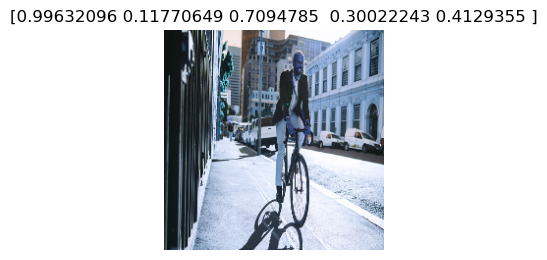

In [86]:
plt.figure(figsize=(20,20))
for n , i in enumerate(list(np.random.randint(0,len(test_images),1))) : 
    plt.subplot(6,6,n+1)
    plt.imshow(test_images[i])    
    plt.axis('off')
    x =np.argmax(preds[i]) # takes the maximum of of the 6 probabilites. 
    plt.title((preds[i]))

In [58]:
result = []
for i in range(len(preds)):
    result.append(np.argmax(preds[i]))

In [59]:
tn, fp, fn, tp = confusion_matrix(val_labels,result).ravel()

NameError: name 'confusion_matrix' is not defined